In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import filters

from opm import make_opm, plot_opm, plot_amplitude_map
from pinwheels import plot_pinwheels
from response import response, create_stimuli, compute_responses

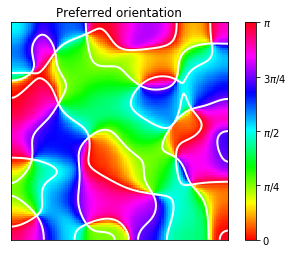

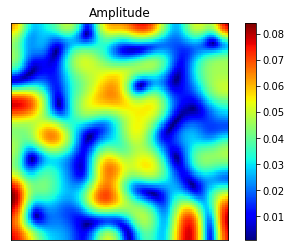

In [2]:
m = make_opm(size=100, sigma=8.)

f, ax = plot_opm(m)
plot_pinwheels(m, ax)

plt.show()

f, ax = plot_amplitude_map(m)

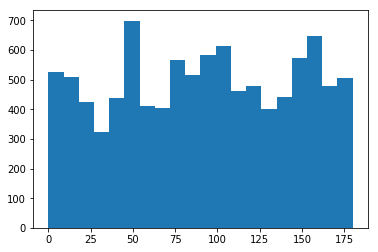

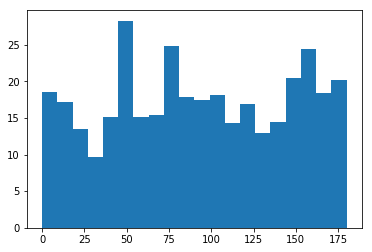

In [3]:
def plot_orientation_histogram(m, weighted=False, bins=20, ax=None):
    if not ax:
        f, ax = plt.subplots()
        
    weights = np.abs(m).reshape(-1) if weighted else None
    
    ax.hist((np.angle(m).reshape(-1) + np.pi) / (2 * np.pi) * 180, bins=bins, weights=weights)
    
    return f, ax
    

plot_orientation_histogram(m)
plt.show()

plot_orientation_histogram(m, weighted=True)
plt.show()

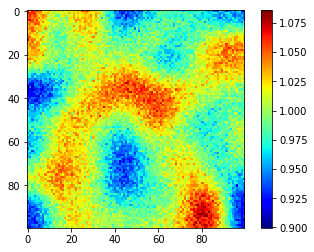

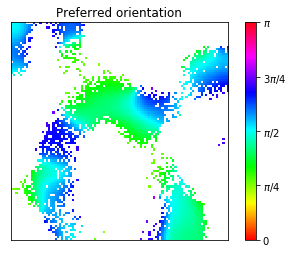

In [4]:
# we now assume we observe a stimulus with contrast c_s and orientation theta_s
c_s = 1.0
theta_s = 2 * np.pi / 4 - np.pi / 2

r = response(m, c_s, theta_s, c=1., sigma=0.01)

# plot response
im = plt.imshow(r, cmap='jet')
#im.set_clim(.7, 1.2)
plt.colorbar()

plt.show()

# check that the orientation that we have chosen is actually the one with the highest activity
mx = m.copy()
mx[np.where(r < 1.02)] = np.nan

plot_opm(mx)
plt.show()

In [14]:
contrasts = [0.25, 0.5, 1.0]
orientations = [i * np.pi / 8 for i in range(8)]
repetitions = 8

S = create_stimuli(contrasts, orientations, repetitions)
R = compute_responses(m, contrasts, orientations, repetitions)

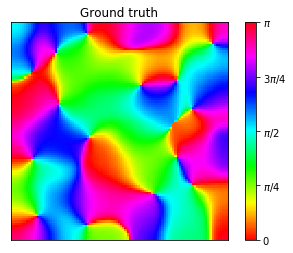

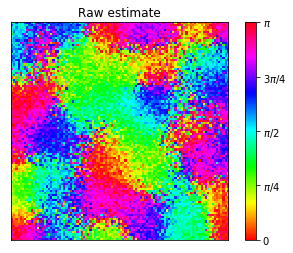

3.1412647681063337

In [15]:
import scipy.stats as ss

# least squares estimate of real and imaginary components of the map
AB = np.linalg.inv(S.T @ S) @ S.T @ R

# compute the complex map
a_hat = AB[0].reshape(100,100)
b_hat = AB[1].reshape(100,100)
c_hat = AB[2].reshape(100,100)
m_hat = a_hat + 1j * b_hat
        

# plot ground truth
plot_opm(m, title='Ground truth')
plt.show()

plot_opm(m_hat, title='Raw estimate')
plt.show()

((np.angle(m_hat) + np.pi) / 2).max()

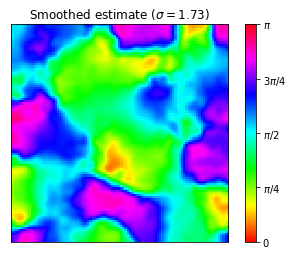

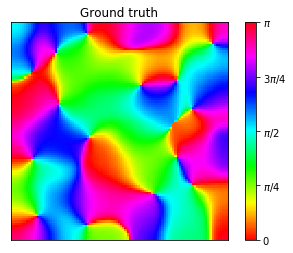

In [16]:
best_corr = -np.inf
best_sigma = np.nan
for sigma in np.linspace(0.01, 10, 100):
    
    # smoothe the estimate of the angle
    theta_smooth = filters.gaussian_filter(0.5 * (np.angle(m_hat) + np.pi), sigma=sigma)
    
    corr = ss.pearsonr(theta_smooth.reshape(-1), 0.5 * (np.angle(m) + np.pi).reshape(-1))[0]
    if corr > best_corr:
        best_corr = corr
        best_sigma = sigma
        best_theta = theta_smooth
        
plot_opm(best_theta, title=r'Smoothed estimate ($\sigma = {0:.2f}$)'.format(best_sigma))
plt.show()


plot_opm(m, title='Ground truth')
plt.show()

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f587472c438>)

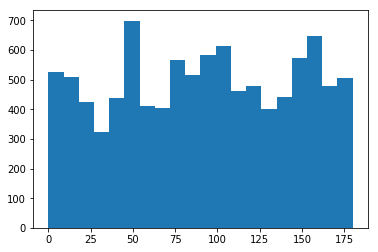

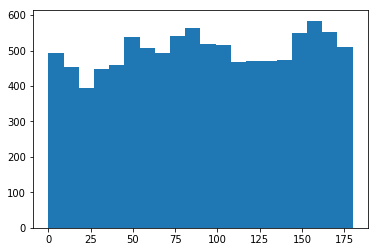

In [17]:
plot_orientation_histogram(m)

plot_orientation_histogram(m_hat)